# Байесовская оптимизация и гауссовские случайные процессы

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

# 0. Введение

На практике часто возникают задачи, в которой вам нужно найти глобальной оптимум функции, причём эти функции переодически бывают не заданы аналитически, долго вычислимы, не выпуклы, у вас нет к ним прямого доступа, они зашумлённые и высокоразмерные (в классической литературе такие функции часто называются "замечательные функции").  

Примеры таких задач:
1. Оптимизация гиперпараметров ML-модели
2. Выбор места для бурения нового месторождения
3. Выбор времени задержки на светофорах
4. Выбор цен на товары в интернет магазине
5. Выбор рекламных объявлений для показа пользователю

![caption](img/smooth.jpeg)

Самым простым методом решения таких задач является grid search, однако часто его использование просто невозможно, так как функция в точке вычисляется очень долго или пространство параметров очень большое.  
Чтобы сделать перебор аргументов функции более "интеллектуальным" можно использовать подход байесовской оптимизации, который мы и рассмотрим в данной тетрадке.

# 1. Многомерное гауссовское распределение
Для начала разберёмся с многомерными распределениями и тем, как из них сэмплировать данные.

### Как строится распределение

Для начала рассмотрим одномерную случайную величину $X \in \mathbb{R}$, которая сэмплируется из нормального распределения $X \sim \mathcal{N}(\mu, \sigma^2)$. 
Функция плотности вероятности нормального распределения (распределение Гаусса) имеет вид 
$$p(x \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{(x - \mu)^2}{2\sigma^2}\right)}$$
где $\mu = \mathbb{E}(X)$ - среднее значение (мат. ожидание) величины, $\sigma$ - стандартное отклонение.  
  
Стандартное отклонение можно определить через понятие дисперсии $Var(x) = \mathbb{E}[\, (X - \mu)^2 \,] = \sigma^2$

In [9]:
def univariate_normal(x, mean, variance):
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

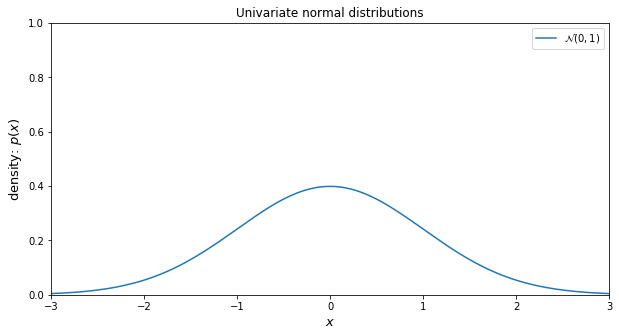

In [8]:
x = np.linspace(-3, 5, num=150)
fig = plt.figure(figsize=(10, 5))
plt.plot(
    x, univariate_normal(x, mean=0, variance=1), 
    label="$\mathcal{N}(0, 1)$")
plt.xlabel('$x$', fontsize=13)
plt.ylabel('density: $p(x)$', fontsize=13)
plt.title('Univariate normal distributions')
plt.ylim([0, 1])
plt.xlim([-3, 3])
plt.legend(loc=1)

Теперь рассмотрим случайную величину $X \in \mathbb{R}^n$ - каждую компоненту её вектора можно рассмотреть, как отдельную случайную величину $\Rightarrow$ нужно ввести совместное распределение на них, так как эти компоненты вполне могут быть зависимыми $p(x_1, x_2 \dots x_n)$. Попробуем обобщить понятие нормального распределения на многомерный случай.  
Если мы имеем две независимые случайные величины, то это функция плотности вероятности этого распределения будет выглядеть просто, как произведение п.в. двух гаусиан. Форма его будет выглядеть, как многомерный колокол, а если взять область, в которую попадает 68.9%, то это будет эллипс, у которого главные оси перпендикулярны.  
Его формула $x^T \Sigma_x^{-1} x = 1$, где $\Sigma = \begin{bmatrix}
\sigma_1^2 & 0 \\
0 & \sigma_2^2
\end{bmatrix}$.

![caption](img/2dnormal.png)

Теперь допустим, что эти переменные зависимы, причём будем рассматривать линейнуя зависимость $X_2 = \alpha X_1 + \beta$, тогда медиана $X_2$ будет меняться ~ $X_1$ с соответствующим коэффициентом и основание распределения будет выглядеть, как эллипс выше, но повёрнутый на соответсвующий градус. И матрица, задающая этот эллипс будет иметь вид $\Sigma_y = u\Sigma_xu^T$, где $\Sigma_x$ - матрица эллипса в оригинальном базисе, а $u$ - координаты повёрнутого базиса.  
Эту матрицу можно записать через ковариацию переменных.
$$Cov(x_1, x_2) = \mathbb{E}[(x_1 - \mathbb{E}(x_1))(x_2 - \mathbb{E}(x_2))] = \mathbb{E}[x_1x_2] - \mathbb{E}[x_1]\mathbb{E}[x_2]$$  
Т.е. ковариация показывает степень линейной зависимости случайных переменных.
![caption](img/corr_coef.png)

Получаем формулу многомерного нормального распределения 
$$p(\mathbf{x} \mid \mathbf{\mu}, \Sigma) = \frac{1}{\sqrt{(2\pi)^d \lvert\Sigma\rvert}} \exp{ \left( -\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \Sigma^{-1} (\mathbf{x} - \mathbf{\mu}) \right)}$$

In [19]:
def multivariate_normal(x, d, mean, covariance):

    x_m = x - mean
    
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [20]:
# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]), 
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

In [23]:
# Подставим разные значения ковариаций и посмотрим на вид распределения
bivariate_covariance = np.matrix([
    [1., 0.6], 
    [0.6, 2.]
])

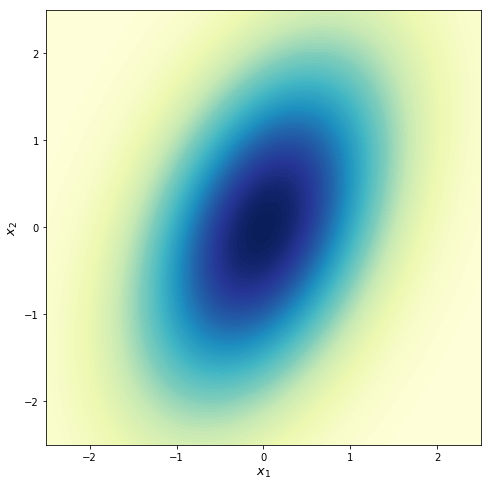

In [24]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
d = 2  # number of dimensions

bivariate_mean = np.matrix([[0.], [0.]])  

x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)

con = ax1.contourf(x1, x2, p, 100, cmap=plt.cm.YlGnBu)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])
ax1.set_aspect('equal')

Таким образом можно обобщить нормальное распределение на многомерный случай.

### Как из него сэмплировать

Теперь посмотрим, как сэмплировать из произвольного нормального распределения. 
Для начала покажем полезное свойство нормального распределения - если взять нормально распределённую величину $X$ и получим новую величину афинным преобразованием $Y = LX + b$, где матрица $L$ задаёт линейное преобразование, то её распределение так же будет нормальным и $\mu_Y = L\mu_X + u$ и $\Sigma_Y = L\Sigma_xL^T$.  

Используя этот факт мы можем сэмплировать точки сначала из распределения $\mathcal{N}(0, E)$, где $E$-единичная матрица и затем привести эти точки к нужному распределению линейным преобразованием.  
Сэмплировать из $\mathcal{N}(0, E)$ проще, чем из произвольного - в нём переменные независимы, а независимые, нормально распределённые переменные можно сэмплировать используя обычный рандомный генератор, который возвращает числа из равномерного распределения (для перехода между равномерным и нормальным распределением можно использовать преобразование [Бокса-Мюллера](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%91%D0%BE%D0%BA%D1%81%D0%B0_%E2%80%94_%D0%9C%D1%8E%D0%BB%D0%BB%D0%B5%D1%80%D0%B0))

При линейном преобразовании данного распределения получим $\Sigma_Y = LL^T \Rightarrow$ при заданной матрице ковариаций нам нужно подобрать такую $L$. Это можно сделать с помощью разложения [Холецкого](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B7%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A5%D0%BE%D0%BB%D0%B5%D1%86%D0%BA%D0%BE%D0%B3%D0%BE), которое позволяет "взять квадрат" матрицы. 

In [40]:
d = 2 

mean = np.matrix([[0.], [1.]])
covariance = np.matrix([
    [1, 0.8], 
    [0.8, 1]
])

L = np.linalg.cholesky(covariance)

n = 50  
X = np.random.normal(size=(d, n))

Y = L.dot(X) + mean

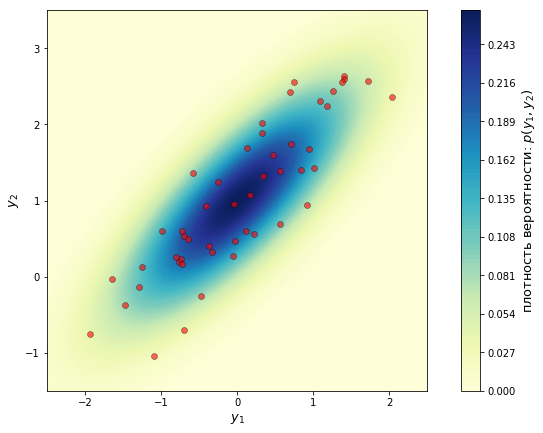

In [44]:
fig, ax = plt.subplots(figsize=(12, 7))

x1, x2, p = generate_surface(mean, covariance, d)
con = ax.contourf(x1, x2, p, 100, cmap=plt.cm.YlGnBu)

ax.plot(Y[0,:], Y[1,:], 'ro', alpha=.6,
        markeredgecolor='k', markeredgewidth=0.5)
ax.set_xlabel('$y_1$', fontsize=13)
ax.set_ylabel('$y_2$', fontsize=13)
ax.axis([-2.5, 2.5, -1.5, 3.5])
ax.set_aspect('equal')
cbar = plt.colorbar(con)
cbar.ax.set_ylabel('плотность вероятности: $p(y_1, y_2)$', fontsize=13)
plt.show()

### Вычисление условной вероятности

Далее, имея функцию совместной вероятности полезно бы было вычислять условную $p(x|y) = \mathcal{N}(\mu_{x|y}, \Sigma_{x|y})$.  
Условное среднее и матрицу ковариаций можно вычислить по формулам 
$$\Sigma_{x|y} = A - CB^{-1}C^T$$
$$\mu_{x|y} = \mu_x + CB^{-1}(y - \mu_y)$$
где матрица ковариации совместного распределения $\Sigma = \begin{bmatrix}
A & C \\
C^T & B
\end{bmatrix}$

In [47]:
# Зададим распределение

d = 2  # dimensions
mean = np.matrix([[0.], [1.]])
cov = np.matrix([
    [1, 0.8], 
    [0.8, 1]
])

mean_x = mean[0,0]
mean_y = mean[1,0]

A = cov[0, 0]
B = cov[1, 1]
C = cov[0, 1]

# Calculate x|y
y_condition = 1.  
mean_xgiveny = mean_x + (C * (1/B) * (y_condition - mean_y))
cov_xgiveny = A - C * (1/B) * C

# Calculate y|x
x_condition = -1.
mean_ygivenx = mean_y + (C * (1/A) * (x_condition - mean_x))
cov_ygivenx = B - (C * (1/A) * C)

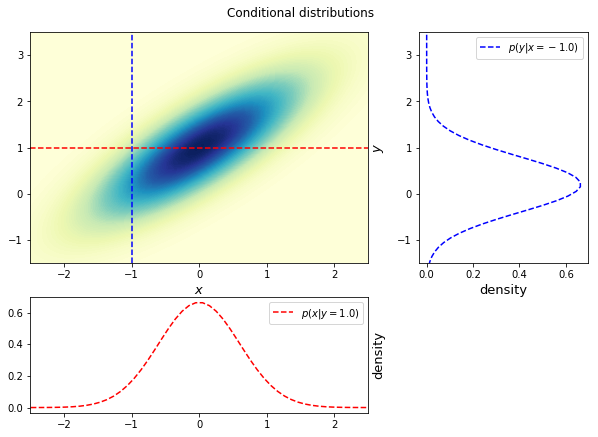

In [54]:
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(
    2, 2, width_ratios=[2, 1], height_ratios=[2, 1])
# gs.update(wspace=0., hspace=0.)
plt.suptitle('Conditional distributions', y=0.93)

# Plot surface on top left
ax1 = plt.subplot(gs[0])
x, y, p = generate_surface(mean, cov, d)
# Plot bivariate distribution
con = ax1.contourf(x, y, p, 100, cmap=plt.cm.YlGnBu)
# y=1 that is conditioned upon
ax1.plot([-2.5, 2.5], [y_condition, y_condition], 'r--')
# x=-1. that is conditioned upon
ax1.plot([x_condition, x_condition], [-1.5, 3.5], 'b--')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.yaxis.set_label_position('right')
ax1.axis([-2.5, 2.5, -1.5, 3.5])

# Plot y|x
ax2 = plt.subplot(gs[1])
yx = np.linspace(-5, 5, num=100)
pyx = univariate_normal(yx, mean_ygivenx, cov_ygivenx)
# Plot univariate distribution
ax2.plot(pyx, yx, 'b--', 
         label=f'$p(y|x={x_condition:.1f})$')
ax2.legend(loc=0)
ax2.set_xlabel('density', fontsize=13)
ax2.set_ylim(-1.5, 3.5)

# Plot x|y
ax3 = plt.subplot(gs[2])
xy = np.linspace(-5, 5, num=100)
pxy = univariate_normal(xy, mean_xgiveny, cov_xgiveny)
# Plot univariate distribution
ax3.plot(xy, pxy, 'r--', 
         label=f'$p(x|y={y_condition:.1f})$')
ax3.legend(loc=0)
ax3.set_ylabel('density', fontsize=13)
ax3.yaxis.set_label_position('right')
ax3.set_xlim(-2.5, 2.5)

# Clear axis 4 and plot colarbar in its place
ax4 = plt.subplot(gs[3])
ax4.set_visible(False)
plt.show()
#

Теперь воспользуемся этими штуками для введения понятия гауссовского случайного процесса.

# 2. Гауссовский случайный процесс 

#### Определение случайного процесса

Случайный процесс - семейство случайных величин, индексированных некоторым параметром (чаще всего пременем или координатой) $\{Y(x)\}_{x \in X}$.  
Примером случайного процесса является температура комната в разных точках или цена акций в течении месяца.  
Случайный процесс определяет семейство функций на данном множестве - каждая функия является одной из реализаций случайного процесса. Если мы рассматриваем функцию на $\mathbb{R}^n$, то нам необходимо ввести бесконечномерный процесс. 
![caption](img/stochproc.png)

#### Гауссовский случайны процесс и его применение в задаче регрессии

Частным случаем случайного процесса является гауссовский - это такой процесс, в котором все его конечномерные распределения имеют нормальное распределение. Т.е. любой конечномерный вектор, образовыннй сечением процесса $X(t)$ имеет нормальное распределение 
$$\forall n, t_1, \dots t_n \vec{X} \sim \mathbb{N}(\mu_x. \Sigma_x)$$

Этот факт делает удобным использование гауссовского процесса для решения задачи регрессии - мы будем составлять семейство функций, которые могли бы описывать зависимость и которые обладают какими-то заранее заданными свойствами и получать распределение значения процесса в интересующей нас точке.  

Выбираем $n$ точек пространства - $f(x_1), f(x_2), \dots f(x_n) \sim \mathbb{N}(\nu, \sigma)$, мы пронаблюдали значение функции в некоторых точках и получили обучающую выборку $D = \{(x_1, f_1), (x_2, f_2), \dots, (x_k, f_k)\}$, таким образом мы можем получить условное распределение на значения в точках вне учебной выборки $f(\textbf{x}) |\, D \sim N(\mu_*, \Sigma_*)$, причём значения среднего и матрицу ковариаций данного распределения можно получить с помощью формул условной вероятности из первого пункта.  

#### Определение среднего и функции ковариации

Правильного метода выбора функции среднего и ковариации для гауссовского процесса нет, однако есть общие правила.  
Значение среднего обычно принимается равным нулю $\mu = 0$.

Функция ковариации определяет семейство функций, которое задаётся нашим распределением. Матрицы ковариации, получающиеся в результате применения нашей функции должны быть симметрическими и неотрицательно определенными.   
Функция ковариации определяет гладкость и диффиринцируемость функций, порождаемых случайным процессом.  
В качестве функции ковариации обычно используются функции от расстояния между точками
$$k(x, y) = Cov(f(x), f(y))$$
Таким образом функция ковариации определяет гладкость функции - определяя консанту Липшеца. 
$$|f(x) - f(y)| \leq L|x - y|$$

Например RBF (radial basis function) функцию в качестве функции ковариации.
$$\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j))$$

_  | _
- | - 
![alt](img/first.png) | ![alt](img/second.png)

Белый шум: 
$$k(x, y) =  \begin{cases} 1, & \mbox{if x = y}  \\ 0, & \mbox{otherwise} \end{cases}$$
![caption](img/white.png)

#### Код

In [1]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [2]:
# Сэмплирование функций из процесса

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)

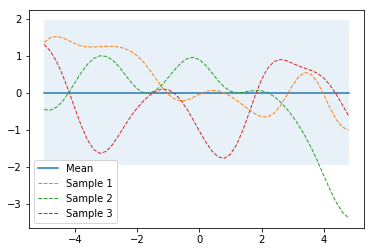

In [9]:
# Конечное количество точек из рассматриваемого пространства
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Начальное распределение
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Сэмплируем функции
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Выведем среднее, сэмплированные функции и доверительный интервал (интервал, в который попадает 95% точек)
plot_gp(mu, cov, X, samples=samples)

In [14]:
def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):

    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K)
    
    # Параметры условного распределения в предсказываемых точках
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

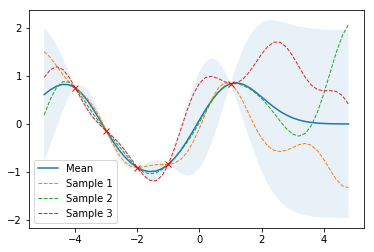

In [15]:
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

В случае зашумлённых данных отклонения в точках обучающей выборки не равна нулю.

Теперь применим гауссовский процесс к задаче оптимизации black-box функции.

# 3. Байесовская оптимизация

Алгоритм байесовской оптимизации с импользованием какой-то суррогатной модели (в нашем случае - гауссовский процесс) достаточно прост:
1. Сэмплируем функцию в произвольных точках и строим начальное распределение возможных оптимизируемых функций 
2. Acquisition функцией оцениваем, в каких точках нам нужно снова сэмлировать функцию
3. Обновляем распределение новыми данными
4. Делаем так $n$ раз, после останавливаемся и возвращаем значение минимума функции, задавемой нашим распределением.
Таким образом мы трансформируем проблему оптимизации функции: $x = argmin_{x\in X}f(x)$ на задачу последовательной максимизации acquisition функции: $x_{n+1} = argmax_{x \in X}\alpha(x, D, \theta)$, которую обычно оценивать дешевле и зачастую нам доступны её градиенты.

#### Формализация задачи

Имеем оптимизируемую, незаданную функцию $f: D \rightarrow \mathbb{R}$, значения которой мы можем запрашивать у оракула. В раунде $t$ мы получаем значение в точке $\textbf{x}_t \in D$, искажённое шумом $y_t = f(\textbf{x}_t) + \epsilon_t$. Теперь нам необходимо найти $\textbf{x}^* = argmax_{\textbf{x} \in D}f(\textbf{x})$.  


Для оценки работы алгоритма используем понятие cumulative regret (суммарное сожаление ?). Regret на каждом шаге $t$ определим, как разницу между оптимальным значением функции и значением на данном шаге $r_t = f(\textbf{x}^*) - f(\textbf{x}_t)$. Тогда суммарный regret $R_T = \sum_{t=1}^T r_t$.  
Если алгоритм сходится, то $lim_{T \rightarrow \infty}R_T/T = 0$.  
Данная постановка задачи эквивалентна задаче многорукого бандита (multiarmed bandit).

Теперь поговорим о том, как можно выбрать acquisition функцию и о чём необходимо для этого подумать.

#### Связь с дизайном экспериментов и теорией информации

Мы можем выбирать новые точки таким образом, чтобы узнать о функции, как можно больше и оценить её как можно точнее, затем выбрать оптимум у оценки функции. Задача об оценке неизвестной black-box функции решается подходом байесовского экспериментального дизайна (дальше ED).  

Будем измерять, насколько информативен набор сэмплированных точек $A \subset D, \textbf{y}_A = \textbf{f}_A + \epsilon_A$ ($\epsilon_A \sim N(\mathbf{0}, \sigma^2\mathbf{I})$)для описание данной функции, как прирост информации (information gain).
$$I(\textbf{y}_A;f) = H(\textbf{y}_A) - H(\textbf{y}_A|f)$$
где H - энтропия Шэнона для непрерывного распределения, $\textbf{y}_A|f$ - полученные от оракула распределения, $\textbf{y}_A$ - распределения, полученные из гауссовского процесса.  
Information gain показывает, насколько много мы узнали информации о $f$, сэмплировава значения $\textbf{y}_A$.
Для нормального распределения $H(N(\mathbf{\mu}, \mathbf{\Sigma})) = \frac{1}{2}\log|2 \pi e \mathbf{\Sigma}|$  
Получаем финальное выражение $I(\mathbf{y}_A; f) = \frac{1}{2}\log|\mathbf{I} + \sigma^{-2}\mathbf{K}_A|$

Поиск множества $A \subset D$, которое будет максимизировать information gain для данной функции является NP-трудной задачей, однако приблизительное решение можно получить жадным алгоритмом, который будет на каждом шаге $t$ и искать $\mathbf{x}_t = argmax_{x \in D}F(A_{t-1}\cup {\mathbf{x}})$, где $F(A) = I(\mathbf{y}_A;f)$. Для нормального распределения максимизируемое условие можно переписать, как 
$$\mathbf{x}_t = arg\max_{\mathbf{x} \in D}\sigma_{t-1}(\mathbf{x})$$

Information gain является submodular функцией (показано в [статье](https://arxiv.org/pdf/1207.1394.pdf)), т.е. 
$$\forall X,Y \subset \Omega, \, X \subset Y \, \rightarrow \, f(X \cup \{x\}) - f(X) \geq f(Y \cup \{x\}) - f(Y)$$
Для таких функций известно, что жадный алгоритм даёт оптимальное с высокое точностью. Конкретно
$$F(A_T) \geq (1 - 1/e)\max_{|A| \leq T}F(A)$$
Далее будем использовать это выражение для оценки алгоритма оптимизации.

#### GP-UCB (Gaussian proccess - upper confidence bound) алгоритм

Оптимизация ED правилом может быть слишком избыточной, так как стремиться уменьшить неизвестность функции на всём пространстве, хотя нам интереснее исследовать пространство в тех областях, где скорее всего находится максимум функции. Однако, если мы будем просто выбирать точки, в которых ожидаемый прирост значения самый большой $\textbf{x}_t = argmax_{x \in D}\mu_{t-1}(\textbf{x})$, то мы сможем застрять в локальном оптимуме и не найти глобальный.  
Эта проблема балансирования исследования (exploration) пространства действия и эксплуатирование уже известной области с оптимумом (exploitation) называется exploration exploitation tradeoff и любая acquisition функция должна учитывать, что обе стратегии важны и каким-то образом балансировать между ними.

В GP-UCB алгоритме используется acquisition функция, совмещающая оба фактора
$$\textbf{x}_t = argmax_{x \in D}\mu_{t-1}(\textbf{x}) + \beta_t^{1/2}\sigma_{t-1}(\textbf{x})$$, где $\beta_t$ - параметр уверенности (confidence parameter).  

Оптимизируемый нами аргумент равен наиболее вероятной верхней оценке на значение функции в данной точке (для распределения $\mathbb{P}(f(\textbf{x}) | \textbf{y}_{t-1})$), т.е. мы выбираем такой $\textbf{x}$, в котором максимальна оценка на значение оптимизируемой функции ( отсюда upper confidence bound )  

## Теоретическая оценка качества работы алгоритма

Теперь оценим сверху качество работы GP-UCB алгоритма для разных вариантов областей определения оптимизируемой функциии.  
Для всех оценок будет важно ввести максимальный information gain
$$\gamma_T := \max_{A \subset D:|A|=T}I(\mathbf{y}_A; \mathbf{f}_A)$$
оценку на который мы тоже дадим.

$\mathbb{O}^*$ - $O$ с опущенными логарифмами.

### Оценка для конечного D

$\textbf{Th.}$  
$\delta \in (0,1), \beta_t = 2\log(|D|t^2 \pi^2 / 6\delta)$  
Cumulative regret алгоритма GP-UCB c параметром уверенности $\beta_t$, медианой 0, функцией ковариации $k(\mathbf{x}, \mathbf{x}^*)$ ограничен $\mathbb{O}^*(\sqrt{T \gamma_T \log|D|})$ с высокой вероятностью.
$$\mathbb{P} \{ R_T \leq \sqrt{C_1T\beta_T\gamma_T} \,  \forall T \geq 1\} \geq 1-\delta$$ 
где $C_1 = 8/\log(1+\sigma^{-2})$ 

$\mathbf{Pr.}$  

$\mathbf{Lemma 1.}:$ Возьмём $\delta \in (0,1)$, $\beta_t = 2\log(|D|\pi_t/\sigma)$, где $\sum_{t\geq1}\pi_t^{-1}=1, \pi_t > 0 \Rightarrow$
$$|f(\mathbf{x}) - \mu_{t-1}(\mathbf{x})| \leq \beta_t^{1/2}\sigma_{t-1}(\mathbf{x}) \,\, \forall \mathbf{x} \in D \forall t \geq 1$$
справедливо с вероятностью $\geq 1-\delta$ 

* Зафиксируем $t \geq 1$ и $\mathbf{x} \in D$. $f(\mathbf{x}) \sim N(\mu_{t-1}(\mathbf{x}), \sigma_{t-1}^2(\mathbf{x}))$.

* $r \sim N(0,1)$ тогда $\mathbb{P}\{r > c\} = \frac{1}{\sqrt{2\pi}}\int_c^{+\infty} e ^ {\frac{1}{2}r^2}dr = \frac{1}{\sqrt{2\pi}} e^{-c^2/2}\int_c^{+\infty} e ^ {\frac{1}{2}(r-c)^2 - c(r-c)}dr \leq |$ т.к. $e^{-c(r-c)} \leq 1$ при $r \geq c$ и $\int_c^{+\infty}e^{-(r-c)^2}dr = \int_0^{+\infty}e^{-p^2}dp$ $| \leq e^{-c^2/2}\mathbb{P}\{r > 0\} = (1/2)e^{-c^2/2}$ 

* Приведём распределение $f(\mathbf{x})$ к стандартному $r = f(\mathbf{x}) - \mu_{t-1}(\mathbf{x})/\sigma_{t-1}(\mathbf{x}) \sim N(0, 1)$ и $c = \beta_t^{1/2}$ получаем $\mathbb{P}\{|f(\mathbf{x}) - \mu_{t-1}(\mathbf{x})| > \beta_t^{1/2}\sigma_{t-1}(\mathbf{x})\} \leq e^{-\beta_t/2}$

* Далее, используя правило union bound ($\mathbb{P}\{\cup A_i\} \leq \sum \mathbb{P}\{A_i\}$) получаем 
$$|f(\mathbf{x}) - \mu_{t-1}(\mathbf{x})| \leq \beta_t^{1/2}\sigma_{t-1}(\mathbf{x}) \,\, \forall \mathbf{x} \in D$$
с вероятностью $\geq 1 - |D|e^{-\beta_t/2}$

* Возьмём $|D|e^{-\beta_t/2} = \delta/\pi_t$ и применяя union bound для $t \in \mathbb{N}$ получаем доказываемое удтверждение.  
  
$\mathbf{Lemma 2.}:$ Зафиксируем $t \geq 1$. Если $\forall \mathbf{x} \in D: \, |f(\mathbf{x}) - \mu_{t-1}(\mathbf{x})| \leq \beta_t^{1/2} \sigma_{t-1}(\mathbf{x}) \Rightarrow$ проигрыш $r_t \leq 2\beta_t^{1/2}\sigma_{t-1}(\mathbf{x}_t)$.

* $\mathbf{x_t}$ максимизирует соответствующее выражение, поэтому получаем, что $\mu_{t-1}(\mathbf{x_t}) + \beta_t^{1/2}\sigma_{t-1}(\mathbf{x}^*) \geq \mu_{t-1}(\mathbf{x^*}) + \beta_t^{1/2}\sigma_{t-1}(\mathbf{x}^*) \geq f(\mathbf{x}^*)$

* Отсюда получаем
$$r_t = f(\mathbf{x}^*) - f(\mathbf{x}_t) \leq \beta_t^{1/2}\sigma_{t-1}(\mathbf{x}_t) + \mu_{t-1}(\mathbf{x}_t - f(\mathbf{x}_t)) \leq 2\beta_t^{1/2}\sigma_{t-1}(\mathbf{x}_t)$$

$\mathbf{Lemma 3.}:$ Можно выразить информационный прирост через отклонение распределения. $\mathbf{f}_T = (f(\mathbf{x}_t)) \in \mathbb{R}^T$:
$$I(\mathbf{y}_T; \mathbf{f}_T) = \frac{1}{2}\sum_{t=1}^T\log(1+\sigma^{-2}\sigma_{t-1}^2(\mathbf{x}_t))$$

* $I(\mathbf{y}_T; \mathbf{f}_T) = H(\mathbf{y}_T) - (1/2)\log|2\pi e \sigma^2 E|$. 
* $H(\mathbf{y}_T) = H(\mathbf{y}_{T-1}) + H(y_{T} | \mathbf{y}_{T-1}) = H(\mathbf{y}_{T-1}) + 1/2\log(2 \pi e(\sigma^2 + \sigma^2_{t-1}(\mathbf{x}_T)))$ далее по индукции.  

$\mathbf{Lemma 4.}:$ C вероятностью $\geq 1 - \delta$:
$$\sum_{t=1}^Tr_t^2 \leq \beta_T C_1 I(\mathbf{y}_T; \mathbf{f}_T) \leq C_1 \beta_T \gamma_T \,\, \forall T \geq 1$$
где $C_1 := 8/ \log(1 + \sigma^{-2}) \geq 8\sigma^2$

* Из предыдущих лемм имеем, что $\mathbb{P}\{r_t^2 \leq 4 \beta_t \sigma_{t-1}^2(\mathbf{x}_t) \forall t \geq 1\} \geq 1 - \delta$
* $\beta_t$ - неуменьшающаяся функция $\Rightarrow 4\beta_t \sigma_{t-1}^2(\mathbf{x}_t) \leq 4 \beta_T \sigma^2(\sigma^{-2}\sigma_{t-1}^2(\mathbf{x}_t)) \leq 4 \beta_T \sigma^2 C_2 \log(1 + \sigma^{-2}\sigma_{t-1}^2(\mathbf{x}_t))$
где $C_2 = \sigma^{-2}/\log(1 + \sigma^{-2})$
* Т.к. $\forall s \in [0, \sigma^{-2}]$ и $\sigma^{-2}\sigma^2_{t-1} (\mathbf{x}_t) \leq \sigma^{-2}k(\mathbf{x}_t,\mathbf{x}_t) \leq \sigma^{-2}$ подставляя неравенства в 3 лемму получаем удтверждение леммы.

Далее применяем неравенство Коши-Буняковского $R_T^2 \leq T\sum_{t=1}^T r_t^2$ и доказываем теорему.

### Для $D \subset \mathbb{R}^d$

$\mathbf{Th.}$  
* $D \subset [0,r]^d$ - компактное, выпуклое множество, $d\in \mathbb{N},\, r > 0$  
* Сэмплируемые функции $f$ из GP c функцией ковариации $k(\mathbf{x}, \mathbf{x}^*)$ c высокой вероятностью имеют ограниченные производные
$$\mathbb{P}\{\sup_{\mathbf{x} \in D}|\partial f / \partial x_j| > L\} \leq ae^{-(L/b)^2}$$ для каких-то констант $a$ и $b$.
* Выбираем $\delta \in (0,1)$, тогда
$$\beta_t = 2\log(t^2 2 \pi^2 / (3\delta)) + 2d\log(t^2dbr\sqrt{\log(4da/\delta)})$$
Cumulative regret алгоритма GP-UCB c параметром уверенности $\beta_t$, медианой 0, функцией ковариации $k(\mathbf{x}, \mathbf{x}^*)$ ограничен $\mathbb{O}^*(\sqrt{d T \gamma_T})$ с высокой вероятностью.
$$\mathbb{P} \{ R_T \leq \sqrt{C_1T\beta_T\gamma_T} + 2 \,  \forall T \geq 1\} \geq 1-\delta$$ 
где $C_1 = 8/\log(1+\sigma^{-2})$ 

### Оценка максимального прироста информации (information gain)

В принципе, мы могли бы оценивать $\gamma_T$ жадным алгритмом, так как с высокой вероятностью эта оценка точная (как мы уже говорили в предыдущих пунктах), однако это досаточно вычислетельно затратно.

Возможно так же оценить information gain чисто аналитически. Этот результат приведён в статье [1].

### Код

In [26]:
# Сгенерим функцию

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

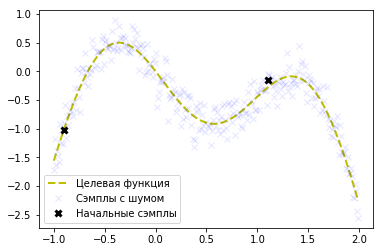

In [27]:
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Функция без шума
Y = f(X,0)
 
plt.plot(X, Y, 'y--', lw=2, label='Целевая функция')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Сэмплы с шумом')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Начальные сэмплы')
plt.legend();

## todo: закодить gp-ucb 

In [28]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [29]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [31]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')


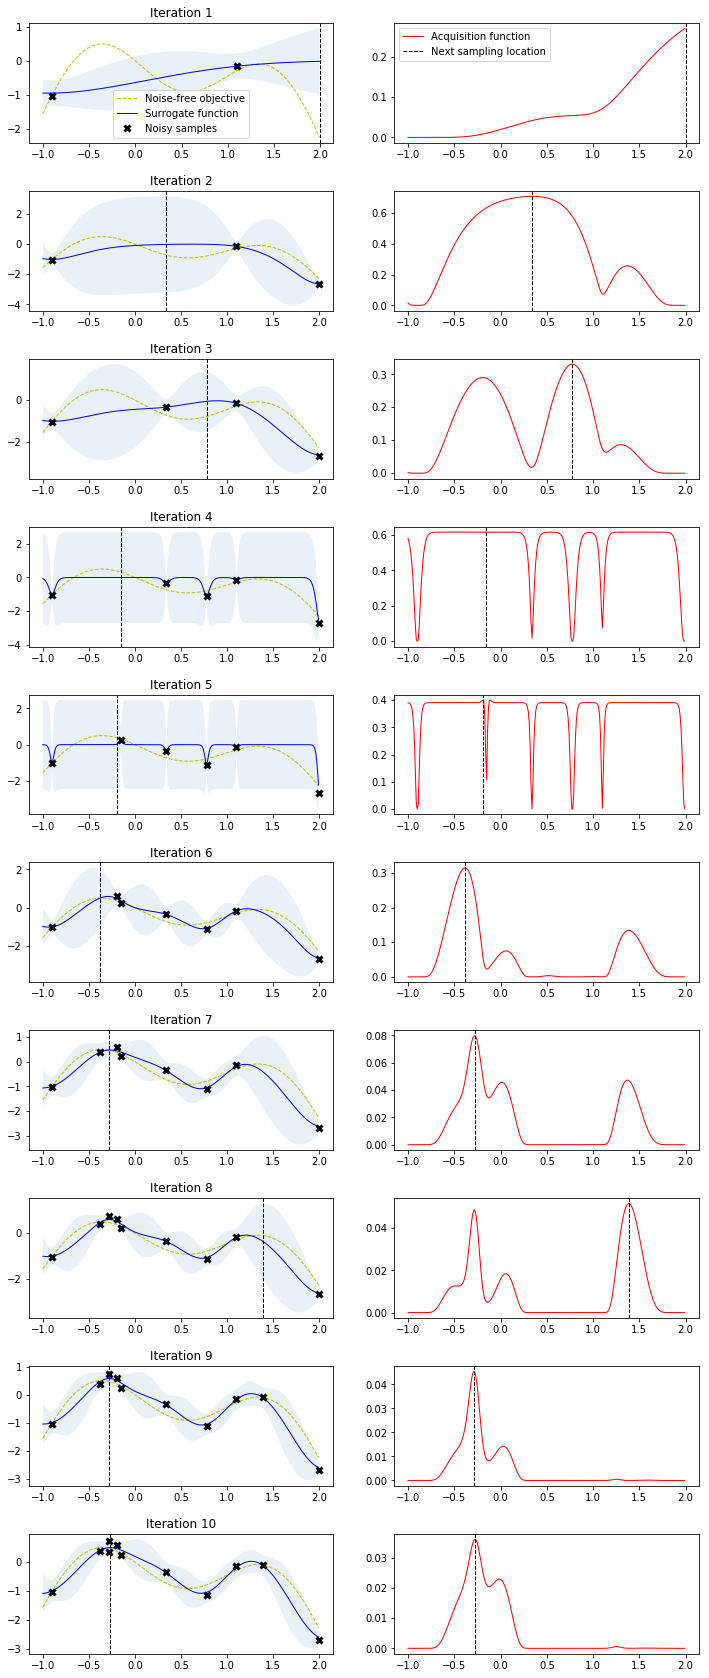

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

### Материалы
[1. Gaussian Process Optimization in the Bandit Setting: No Regret and Experimental Design. N. Srinivas](https://arxiv.org/pdf/0912.3995.pdf)  
[2. Another introduction to Gaussian Processes. Richard Wilkinson](http://gpss.cc/gpss17/slides/Wilkinson2017.pdf)  
[3. Gaussian proccesses tutorial. Martin Krasser](https://krasserm.github.io/2018/03/19/gaussian-processes/)  
[4. Introduction to bayesian optimization. Javier Gonzalez](http://gpss.cc/gpss17/slides/gpss_bayesopt2017.pdf)  
[5. Bayesian optimization tutorial. Martin Krasser](https://krasserm.github.io/2018/03/21/bayesian-optimization/)  
[6. Multivariate gaussian distributions. Peter Roelants.](https://peterroelants.github.io/posts/multivariate-normal-primer/)  
[7. Gaussian processes lecture. UBC](https://www.cs.ubc.ca/~nando/540-2013/lectures/l6.pdf)  
[8. Теория вероятностей. Натан, Горбачёв, Гуз](http://www.combook.ru/product/10006534/)  
[9. Learning with spectral kernels. Markus Heinonen](https://www.hiit.fi/wp-content/uploads/2018/04/Spectral-Kernels-S12.pdf)  